In [2]:
import numpy as np
import torch
import pandas as pd
import odbo
import os
import gc

In [3]:
random_seed = 8
np.random.seed(random_seed)
data_test = pd.read_csv('../datasets/BGL3_2015_26654.csv', sep=',')
name_pre, Y_test = np.array(data_test['AACombo']), np.array(data_test['Log2Escore'])
Y_test = 2**Y_test
del data_test
if os.path.isfile('sele_indices_BGL3_2015.npy') == True:
    sele_indices = np.load('sele_indices_BGL3_2015.npy')
    shuffle_order = np.load('shuffle_order_BGL3_2015.npy')
    name_pre[1:], Y_test[1:] = name_pre[shuffle_order[1:]], Y_test[shuffle_order[1:]]
    name = odbo.utils.code_to_array(name_pre)    
else:
    shuffle_order = np.arange(len(Y_test))
    np.random.shuffle(shuffle_order[1:])
#    np.save('shuffle_order_BGL3_2015.npy', shuffle_order)
    name_pre[1:], Y_test[1:] = name_pre[shuffle_order[1:]], Y_test[shuffle_order[1:]]
    name = odbo.utils.code_to_array(name_pre)
    sele_indices = odbo.initialization.initial_design(name, least_occurance=np.ones(500),allow_abundance=True,update_method='correlate',verbose=True)
#    np.save('sele_indices_BGL3_2015.npy', sele_indices)
name_sele, Y_train = name[sele_indices, :], Y_test[sele_indices]
ids_keep = np.delete(range(len(Y_test)), sele_indices)
name, Y_test = name[ids_keep, :], Y_test[ids_keep]
print('Selected initial experiments no. is ', len(Y_train))
print('Select max Y: ', Y_train.max(), 'True max Y:', Y_test.max())


Current selected experiments:  0 Max pending score:  1.0
Current selected experiments:  2130 Max pending score:  1.0
Current selected experiments:  2468 Max pending score:  1.0
Current selected experiments:  3275 Max pending score:  1.0
Current selected experiments:  10996 Max pending score:  1.0
Current selected experiments:  11927 Max pending score:  1.0
Current selected experiments:  12158 Max pending score:  1.0
Current selected experiments:  24959 Max pending score:  1.0
Current selected experiments:  25085 Max pending score:  1.0
Current selected experiments:  49 Max pending score:  1.0
Current selected experiments:  59 Max pending score:  1.0
Current selected experiments:  271 Max pending score:  1.0
Current selected experiments:  389 Max pending score:  1.0
Current selected experiments:  690 Max pending score:  1.0
Current selected experiments:  800 Max pending score:  1.0
Current selected experiments:  888 Max pending score:  1.0
Current selected experiments:  893 Max pending 

Current selected experiments:  15633 Max pending score:  1.0
Current selected experiments:  16799 Max pending score:  1.0
Current selected experiments:  17751 Max pending score:  1.0
Current selected experiments:  18314 Max pending score:  1.0
Current selected experiments:  20769 Max pending score:  1.0
Current selected experiments:  24842 Max pending score:  1.0
Current selected experiments:  25415 Max pending score:  1.0
Current selected experiments:  25984 Max pending score:  1.0
Current selected experiments:  1421 Max pending score:  1.0
Current selected experiments:  7830 Max pending score:  1.0
Current selected experiments:  9016 Max pending score:  1.0
Current selected experiments:  9025 Max pending score:  1.0
Current selected experiments:  11596 Max pending score:  1.0
Current selected experiments:  12750 Max pending score:  1.0
Current selected experiments:  14022 Max pending score:  1.0
Current selected experiments:  16425 Max pending score:  1.0
Current selected experiments

In [4]:
feature_model = odbo.featurization.FewFeatureTransform(raw_vars=name_sele, Y=Y_train, method='Avg', mode='hybrid')
X_test = feature_model.transform(name)
X_train = feature_model.transform(name_sele)

2.067624696805181
[17:34:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Correct ratio: 78.187%
FN ratio: 6.270%
FP ratio: 15.543%


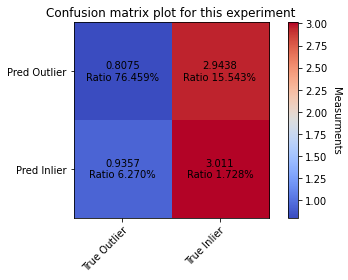

In [5]:
# Find the adaptive search space model
threshold = Y_train[np.argsort(Y_train)[int(0.8*len(Y_train))]]
print(threshold)
labels_train = odbo.prescreening.sp_label(X_train, Y_train, thres=threshold)
pre_model = odbo.prescreening.XGBOD(eval_metric = 'error', random_state = random_seed)
pre_model.fit(X_train, labels_train)
pred_labels = pre_model.predict(X_train)
labels_test = odbo.prescreening.sp_label(X_test, Y_test, thres=threshold)
pred_test_labels = pre_model.predict(X_test)
# Plot the confusion matrix to check the accuracy of search space prescreening
out_outlier, in_outlier, out_inlier, in_inlier = odbo.plot.plot_cm(labels_test, pred_test_labels, Y_test)
print("Correct ratio: {0:.3%}".format((len(out_outlier)+len(in_inlier))/len(labels_test)))
print("FN ratio: {0:.3%}".format(len(out_inlier)/len(labels_test)))
print("FP ratio: {0:.3%}".format(len(in_outlier)/len(labels_test))) 

## ODBO, BO

In [6]:
X_train_sele, Y_train_sele = torch.tensor(X_train), torch.tensor(Y_train.reshape(len(Y_train),1))
sele_id_test = list(np.where(pred_test_labels == 0)[0])
search_name_sele, name_sele_temp = name[sele_id_test, :], name_sele
X_test_sele, Y_test_sele = torch.tensor(X_test[sele_id_test, :]), torch.tensor(Y_test[sele_id_test].reshape(len(sele_id_test),1))
print("Prescreening size: ", len(sele_id_test))

## Run BO experiment with robust regression or directly gp
l, search_iter = 0, 50
batch_size = 1
gp_method='robust_regression'
failure_count = 0
while l < search_iter:
    print("Iter: ", l, "Current Max: ", Y_train_sele.max().detach().numpy(), "Test max: ", Y_test_sele.max().detach().numpy())
    top_ids = np.argsort(Y_train_sele.numpy().ravel())[-40-l:]
    sele_feat = []
    for i in range(X_train_sele.shape[1]):
        if (X_train_sele[top_ids,i]-X_train_sele[0,i]).any() !=0:
            sele_feat.append(i)
    X_sele = X_train_sele[:,sele_feat]
    X_test_sele=X_test_sele[:, sele_feat]
    X_next, acq_value, next_exp_id = odbo.bo_design(X=X_sele[top_ids, :], Y=Y_train_sele[top_ids], X_pending=X_test_sele, gp_method=gp_method, batch_size=batch_size)
    Y_train_sele = torch.cat([Y_train_sele, Y_test_sele[next_exp_id]])
    ids_keep = list(np.delete(range(X_test_sele.shape[0]), next_exp_id))
    Y_test_sele = Y_test_sele[ids_keep]
    name_sele_temp = np.concatenate((name_sele_temp, search_name_sele[next_exp_id]))
    search_name_sele = search_name_sele[ids_keep]
    print("Newly added value: ", Y_train_sele[-batch_size:].detach().numpy(), ''.join(name_sele_temp[-1, :]))

    if Y_train_sele[-batch_size:].detach().numpy().max() > Y_train_sele[:-batch_size].max():
        failure_count = 0
        feature_model1 = odbo.featurization.FewFeatureTransform(raw_vars=name_sele_temp, Y=Y_train_sele.detach().numpy(), method='Avg', mode='hybrid')
    else:
        failure_count = failure_count + 1
        if failure_count >= 3:
            feature_model1 = odbo.featurization.FewFeatureTransform(raw_vars=name_sele_temp, Y=Y_train_sele.detach().numpy(), method='Avg', mode='hybrid')
        else:
            feature_model1 = odbo.featurization.FewFeatureTransform(raw_vars=name_sele_temp, Y=Y_train_sele.detach().numpy(), method='Max', mode='hybrid')

    X_test_sele= torch.tensor(feature_model1.transform(search_name_sele))
    X_train_sele = torch.tensor(feature_model1.transform(name_sele_temp))
    l = l + 1
    
#np.save('results/BRCA1_2013/BRCA1_2013_ODBO_BO_RobustGP_batch1_{}.npy'.format(random_seed), Y_train_sele)


Prescreening size:  2115
Iter:  0 Current Max:  6.149081722168088 Test max:  13.849314113283947
Newly added value:  [[0.93123726]] VPAAQQTAMAPDAALTFPEGFLWGSATASYQIEGAAAEDGRTPSIWDTYARTPGRVRNGDTGDVATDHYHRWREDVALMAELGLGAYRFSLAWPRIQPTGRGPALQKGLDFYRRLADELLAKGIQPVATLYHWDLPQELENAGGWPERATAERFAEYAAIAADALGDRVKTWTTLNEPWCSAFLGYGSGVHAPGRTDPVAALRAAHHLNLGHGLAVQALRDRLPADAQCSVTLNIHHVRPLTDSDADADAVRRIDALANRVFTGPMLQGAYPEDLVKDTAGLTDWSFVRDGDLRLAHQKLDFLGVNYYSPTLVSEADGSGTHNSDGHGRSAHSPWPGADRVAFHQPPGETTAMGWAVDPSGLYELLRRLSSDFPALPLVITENGAAFHDYADPEGNVNDPERIAYVRDHLAAVHRAIKDGSDVRGYFLWSLLDNFEWAHGYSKRFGAVYVDYPTGTRIPKASARWYAEVARTGVLPTAGDPNSSSVDKHAAALEHHHHHH
Iter:  1 Current Max:  6.149081722168088 Test max:  13.849314113283947
Newly added value:  [[1.02608278]] VPAAQQTAMAPDAALTFPEGFLWGSATASYQIEGAAAEDGRTPSIWDTYARTPGRVRNGDTGDVATDHYHRWREDVALMAELGLGAYRFSLAWPRIQPTGRGPALQKGLDFYRRLADELLAKGIQPVATLYHWDLPQELENAGGWPERATAERFAEYAAIAADALGDRVKTWTTLNEPWCSAFLGYGSGVHAPGRTDPVAALRAAHHLNLGHGLAVQALRDRLPADAQCSVTLNIHHVRPLTDSDADADAVRRIDALANRVF

Iter:  14 Current Max:  6.149081722168088 Test max:  13.849314113283947
Newly added value:  [[0.39231355]] VPAAQQTAMAPDAALTFPEGFLWGSATASYQIEGAAAEDGRTPSIWDTYARTPGRVRNGDTGDVATDHYHRWREDVALMAELGLGAYRFSLAWPRIQPTGRGPALQKGLDFYRRLADELLAKGIQPVATLYHWDLPQELENAGGWPERATAERFAEYAAIAADALGDRVKTWTTLNEPWCSAFLGYGSGVHAPGRTDPVAALRAAHHLNLGHGLAVQALRDRLPADAQCSVTLNIHHVRPLTDSDADADAVRRIDALANRVFTGPMLQGAYPEDLVKDTAGLTDWSFVRDGDLRLAHQKLDFLGVNYYSPTLVSEADGSGTHNSDGHGRSAHSPWPGADRVAFHQPPGETTAMGWAVDPSGLYELLRRLSSDFPALPLVITENGAAFHDYADPEGNVNDPERIAYVRDHLAAVHRAIKDGSDVRGYFLWSLLDNFEWAHGYSKRFGAVYVDYPTGTRIPKASARWYAEVVRTGVLPTAGDPSSSSVDKLAAALEHHHHHH
Iter:  15 Current Max:  6.149081722168088 Test max:  13.849314113283947
Newly added value:  [[0.26103088]] VPAAQQTAMAPDAALTFPEGFLWGSATASYQIEGAAAEDGRTPSIWDTYARTPGRVRNGDTGDVATDHYHRWREDVALMAELGLGAYRFSLAWPRIQPTGRGPALQKGLDFYRRLADELLAKGIQPVATLYHWDLPQELENAGGWPERATAERFAEYAAIAADALGDRVKTWTTLNEPWCSAFLGYGSGVHAPGRTDPVAALRAAHHLNLGHGLAVQALRDRLPADAQCSVTLNIHHVRPLTDSDADADAVRRIDALANRVFTGPMLQGAYPEDLVKDTAGLTDW

KeyboardInterrupt: 

## ODBO, TuRBO

In [ ]:
X_train_sele, Y_train_sele = torch.tensor(X_train), torch.tensor(Y_train.reshape(len(Y_train),1))
sele_id_test = list(np.where(pred_test_labels == 0)[0])
search_name_sele, name_sele_temp = name[sele_id_test, :], name_sele
X_test_sele, Y_test_sele = torch.tensor(X_test[sele_id_test, :]), torch.tensor(Y_test[sele_id_test].reshape(len(sele_id_test),1))
print("Prescreening size: ", len(sele_id_test))

# Run BO experiment with robust regression or directly GP
l, search_iter = 0, 50
gp_method='gp_regression'
tr_length = [3.2]
batch_size = 1
failure_count = 0
state = odbo.turbo.TurboState(dim=X_train_sele.shape[1], batch_size=batch_size, length=tr_length, n_trust_regions=len(tr_length), failure_tolerance = 10)
state.best_value = Y_train_sele.max()
while l < search_iter:
    print("Iter: ", l, "Current Max: ", Y_train_sele.max().detach().numpy(), 'TR length: ', state.length, "Test max: ", Y_test_sele.max().detach().numpy())
    top_ids = np.argsort(Y_train_sele.numpy().ravel())[-40-l:]
    sele_feat = []
    for i in range(X_train_sele.shape[1]):
        if (X_train_sele[top_ids,i]-X_train_sele[0,i]).any() !=0:
            sele_feat.append(i)
    X_sele = X_train_sele[:,sele_feat]
    X_test_sele=X_test_sele[:, sele_feat]
    X_next, acq_value, raw_next_exp_id = odbo.turbo_design(state=state, X=X_sele[top_ids, :], Y=Y_train_sele[top_ids], X_pending=X_test_sele, n_trust_regions=len(tr_length), batch_size=batch_size, gp_method=gp_method)
    Y_next_m = torch.zeros((len(tr_length), batch_size, 1), device=Y_train_sele.device, dtype=Y_train_sele.dtype)
    next_exp_id = []
    
    for i in range(batch_size):
        next_exp_id_m = raw_next_exp_id[:, i]
        Y_next_m[:, i, 0], idtoadd = Y_test_sele[next_exp_id_m].reshape(len(tr_length)), next_exp_id_m[np.argmax(Y_test_sele[next_exp_id_m])]
        if idtoadd >= len(Y_test_sele):
            next_exp_id.append(idtoadd-len(Y_test_sele))
        else:
            next_exp_id.append(idtoadd)
        
    Y_train_sele = torch.cat([Y_train_sele, Y_test_sele[next_exp_id]])
    ids_keep = list(np.delete(range(X_test_sele.shape[0]), next_exp_id))
    Y_test_sele = Y_test_sele[ids_keep]
    name_sele_temp = np.concatenate((name_sele_temp, search_name_sele[next_exp_id]))
    search_name_sele = search_name_sele[ids_keep]
    print("Newly added value: ", Y_train_sele[-batch_size:].detach().numpy(), ''.join(name_sele_temp[-1, :]))
    state = odbo.turbo.update_state(state=state, Y_next=Y_next_m)
    if Y_train_sele[-batch_size:].detach().numpy().max() > Y_train_sele[:-batch_size].max():
        failure_count = 0
        feature_model1 = odbo.featurization.FewFeatureTransform(raw_vars=name_sele_temp, Y=Y_train_sele.detach().numpy(), method='Max', mode='hybrid')
    else:
        failure_count = failure_count + 1
        if failure_count >= 3:
            feature_model1 = odbo.featurization.FewFeatureTransform(raw_vars=name_sele_temp, Y=Y_train_sele.detach().numpy(), method='Avg', mode='hybrid')
        else:
            feature_model1 = odbo.featurization.FewFeatureTransform(raw_vars=name_sele_temp, Y=Y_train_sele.detach().numpy(), method='Max', mode='hybrid')
    X_test_sele= torch.tensor(feature_model1.transform(search_name_sele))
    X_train_sele = torch.tensor(feature_model1.transform(name_sele_temp))

    l = l + 1
#np.save('results/BRCA1_2013/BRCA1_2013_ODBO_TuRBO_GP_batch1_{}.npy'.format(random_seed), Y_train_sele)



## Random selection

In [66]:
sele_Y = list(np.random.choice(Y_test, 50, replace = False))
Y_train_sele = list(Y_train.copy())
Y_train_sele.extend(sele_Y)
print('Max Y', max(sele_Y))
np.save('results/BRCA1_2013/BRCA1_2013_random_{}.npy'.format(random_seed), Y_train_sele)

Max Y 2.367313952
